In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re
# Natural Language Tool Kit
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
import cufflinks as cf
cf.go_offline()

#%%
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission =  pd.read_csv("sample_submission.csv")




In [2]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
test.head()


id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
missing = train.isnull().sum()  
missing[missing>0].sort_values(ascending=False).iplot(
    kind='bar',
    title='Null values present in train Dataset', 
    color=['red'])

In [17]:
import plotly.express as px
pie_data = train.target.value_counts()

fig = px.pie(pie_data,title='Population of European continent')
fig.show()
train.target.value_counts().iplot(
    kind='bar',
    text=['Fake', 'Real'], 
    title='Comparing Tweet is a real disaster (1) or not (0)',
    color=['blue'])



In [18]:
train['length'] = train['text'].apply(len)

In [19]:
train.keyword.nunique()

221

In [20]:
train.keyword.value_counts()[:20].iplot(kind='bar', title='Top 20 keywords in text', color='red')


In [21]:
train.location.value_counts()[:20].iplot(kind='bar', title='Top 20 location in tweet', color='blue')  # Check the top 15 locations 

In [26]:
STOPWORDS.add('https')  # remove htps to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 


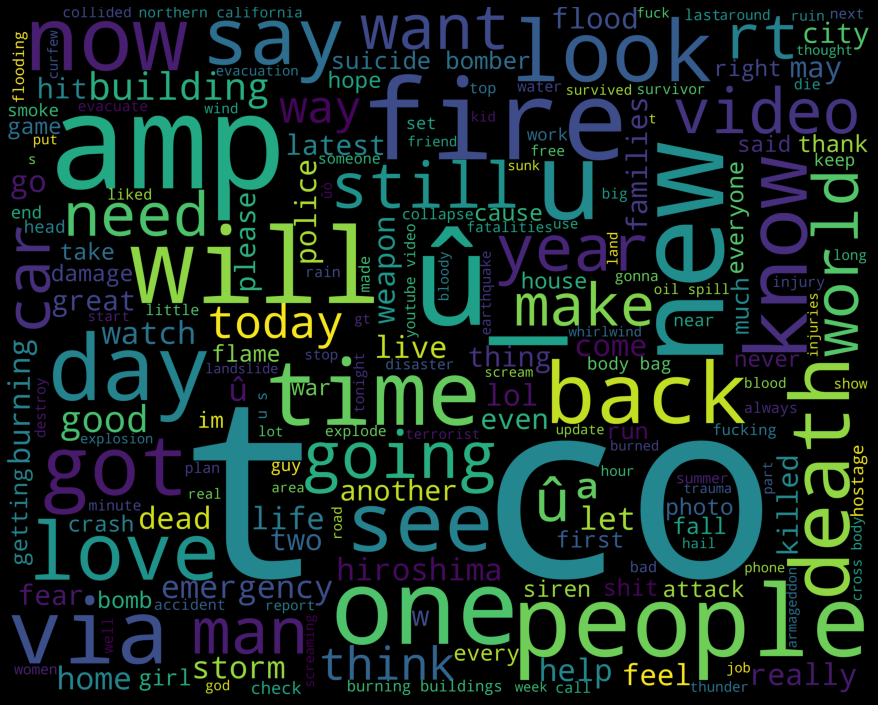

In [27]:
text = train.text.values

Plot_world(text)

In [28]:
train.loc[train['text'].str.contains('http')].target.value_counts()

1    2172
0    1799
Name: target, dtype: int64

In [29]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

In [30]:
# Remove all text that start with html
train['text']=train['text'].apply(lambda x : remove_html(x))

In [31]:
# lets check if this clean works
train.loc[train['text'].str.contains('http')].target.value_counts()


0    1
Name: target, dtype: int64

In [32]:
# Remove all text that start with html in test
test['text']=test['text'].apply(lambda x : remove_html(x))

In [33]:
def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

In [34]:
text = train.text[3]
print(text)
clean_text(text)

13,000 people receive #wildfires evacuation orders in California 


'people receive wildfires evacuation orders california'

In [35]:
# Apply clean text 
train['text'] = train['text'].apply(lambda x : clean_text(x))
# Apply clean text 
test['text']=test['text'].apply(lambda x : clean_text(x))

In [36]:
# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [37]:
text_values = train["text"]

counter = counter_word(text_values)
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 16070


[('deeds', 2),
 ('reason', 20),
 ('earthquake', 50),
 ('may', 89),
 ('allah', 9),
 ('forgive', 2),
 ('us', 128),
 ('forest', 66),
 ('fire', 254),
 ('near', 56)]

In [38]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [39]:
# this is base in 80% of the data, an only text and targert at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]
print('The Shape of training ',training_sentences.shape)
print('The Shape of testing',testing_sentences.shape)

The Shape of training  (6090,)
The Shape of testing (1523,)


In [40]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

# If you want to see completed -> word_index

THe first word Index are: 
 <XXX>,  1 
 amp,  2 
 like,  3 
 fire,  4 
 get,  5 
 via,  6 
 new,  7 
 people,  8 
 news,  9 
 emergency,  10 
 one,  11 
 disaster,  12 
 body,  13 
 video,  14 
 burning,  15 


In [41]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, 
                                maxlen=max_length, 
                                padding=padding_type, 
                                truncating=trunc_type)
print(train.text[1])
print(training_sequences[1])

forest fire near la ronge sask canada
[74, 4, 120, 571, 5480, 5481, 1184]


In [42]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Lets see the first 10 elements
print("THe first reverse word Index are: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))

# If you want to see completed -> reverse_word_index

THe first reverse word Index are: 
 1,  <XXX> 
 2,  amp 
 3,  like 
 4,  fire 
 5,  get 
 6,  via 
 7,  new 
 8,  people 
 9,  news 
 10,  emergency 
 11,  one 
 12,  disaster 
 13,  body 
 14,  video 
 15,  burning 


In [43]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
decode(training_sequences[1]) # this can be usefull for check predictions

'forest fire near la ronge sask canada'

In [44]:
training_padded[1628]

array([7779, 1150, 2107,  629, 2106, 1257,   52,  326, 2106, 1257,   52,
        326, 7780,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [45]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [108]:
from keras.regularizers import l2
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 32)            514240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 565,205
Trainable params: 565,205
Non-trainable params: 0
_________________________________________________________________


In [110]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', 
           show_shapes=True, 
           show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [111]:


start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Epoch 1/10
191/191 [==============================] - 6s 17ms/step - loss: 0.5932 - accuracy: 0.6772 - val_loss: 0.4675 - val_accuracy: 0.7873
Epoch 2/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3486 - accuracy: 0.8650 - val_loss: 0.4714 - val_accuracy: 0.7833
Epoch 3/10
191/191 [==============================] - 3s 14ms/step - loss: 0.2165 - accuracy: 0.9268 - val_loss: 0.6510 - val_accuracy: 0.7301
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.1645 - accuracy: 0.9491 - val_loss: 0.6701 - val_accuracy: 0.7360
Epoch 5/10
191/191 [==============================] - 3s 14ms/step - loss: 0.1265 - accuracy: 0.9568 - val_loss: 1.0131 - val_accuracy: 0.6967
Epoch 6/10
191/191 [==============================] - 3s 15ms/step - loss: 0.1165 - accuracy: 0.9606 - val_loss: 0.8365 - val_accuracy: 0.7157
Epoch 7/10
191/191 [==============================] - 3s 15ms/step - loss: 0.0950 - accuracy: 0.9657 - val_loss: 1.4309 - val_accuracy: 0.6861

In [54]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

loss  accuracy  val_loss  val_accuracy
0  0.553364  0.707225  0.476700      0.776756
1  0.292039  0.887849  0.495253      0.755089
2  0.163083  0.945813  0.636949      0.701904
3  0.120551  0.962726  0.658299      0.734077
4  0.096827  0.970443  0.664079      0.740643

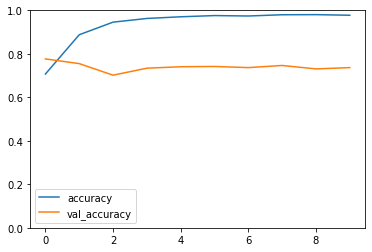

In [55]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);

In [56]:
predictions = model.predict_classes(testing_padded)   # predict_ clases because is classification problem with the split test
predictions

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [58]:
tf.__version__

'2.6.0'

In [77]:
predict_x=model.predict(testing_padded)
classes_x = (predict_x>0.5)

In [78]:
classes_x

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [79]:
from sklearn.metrics import classification_report,confusion_matrix
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

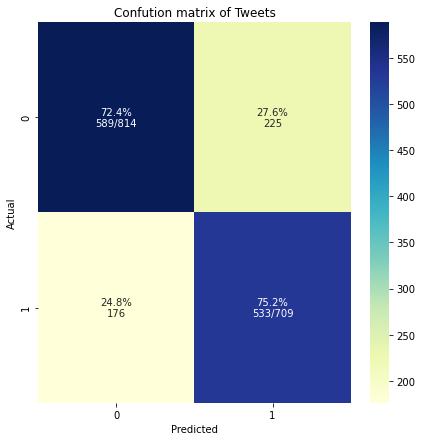

In [80]:
plot_cm(testing_labels,classes_x, 'Confution matrix of Tweets', figsize=(7,7))

In [76]:
testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(testing_padded2)
# sample of submission
submission.head()

id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

In [81]:
submission['target'] = (predictions > 0.5).astype(int)
submission

id  target
0         0       0
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]

In [94]:

submission.target.value_counts()

0    1862
1    1401
Name: target, dtype: int64

In [95]:
submission.to_csv("submission.csv", index=False, header=True)
